In [2]:
%%capture --no-display
!pip install moviepy
!pip install --upgrade tvb-library
!pip install --upgrade tvb-data

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import tvb_model_reference.src.nuu_tools_simulation_human as tools

from tvb_model_reference.simulation_file.parameter.parameter_M_Berlin import Parameter
from tvb_model_reference.view.plot_human import multiview_one, prepare_surface_regions_human
from analyses import *

parameters = Parameter()

/home/master/anaconda3/envs/tvbadexgraph/lib/python3.10/site-packages/tvb/datatypes/surfaces.py:63: UserWarning: Geodesic distance module is unavailable; some functionality for surfaces will be unavailable.
  warnings.warn(msg)


# Load results

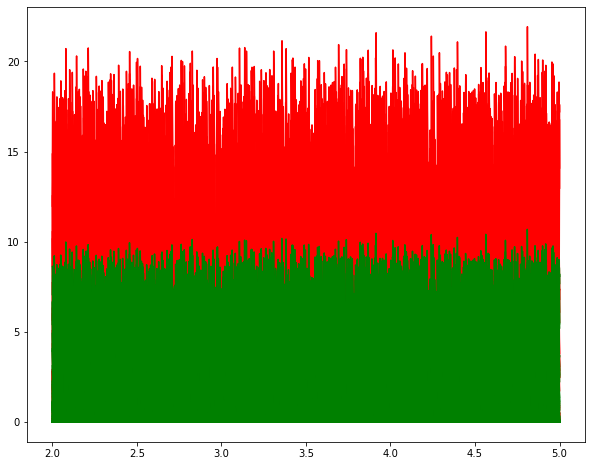

In [2]:
# Select a folder_root

folder_root = '/media/master/Nuevo vol/Internship/Data/hpc_tvbadex/results/' #
folder_root = os.getcwd() + '/results/'
# Define the parameters that we will use
cut_transient = 2000.0
run_sim = 5000.0
S = 0.0
b_e = 0.0
E_L_e = -80.0
E_L_i = -80.0
T = 5.0
fig, ax = plt.subplots(1, 1, figsize=(10, 8))

label_sim = '_a_' + str(S) + '_b_' + str(b_e) + '_ELI_' + str(E_L_i) + \
            '_ELE_' + str(E_L_e) + '_T_' + str(T) + '/'

file_name = folder_root + label_sim

# Draw plots of the firing rates
result = tools.get_result(file_name,cut_transient,run_sim)
time_s = result[0][0]*1e-3 #from ms to sec
FR_exc = result[0][1][:,0,:]*1e3 # from KHz to Hz; Excitatory firing rate
FR_inh = result[0][1][:,1,:]*1e3 # from KHz to Hz; Inhibitory firing rate
del result

ax.plot(time_s, FR_inh, label=r'$v_i$', c='r')
ax.plot(time_s, FR_exc, label=r'$v_e$', c='g')
#ax.set(title=f'S: {S}', xlabel='Time(s)', ylabel='FR(Hz)',
#      xlim=(2, 5), ylim=(0, 5 + max([np.amax(FR_exc), np.amax(FR_inh)])))
plt.show()

# Test up and down state duration code

In [3]:
@njit
def obtain_updown_durs(train_bool, dt):
    N = train_bool.size
    up_durs = np.empty(0)  # Something of the like up_durs = []
    down_durs = np.empty(0)
    current_up_duration = 0
    current_down_duration = 0
    for i in range(1, N):  # We sweep over all the values of the train_bool signal
        if train_bool[i - 1] == train_bool[i]:  # If 2 consecutive equal values -> increase state duration
            if train_bool[i - 1] == 1:
                current_up_duration += dt
            else:
                current_down_duration += dt
        else:  # If 2 consecutive NOT equal values -> increase state duration + store duration + restore
            if train_bool[i - 1] == 1:
                up_durs = np.append(up_durs, current_up_duration)
                current_up_duration = 0
            else:
                down_durs = np.append(down_durs, current_down_duration)
                current_down_duration = 0
        if i == N - 1:  # Regardless of the value of the last time point, we have to store the last duration.
            if train_bool[i] == 1:
                current_up_duration += dt
                up_durs = np.append(up_durs, current_up_duration)
                current_up_duration = 0
            else:
                current_down_duration += dt
                down_durs = np.append(down_durs, current_down_duration)
                current_down_duration = 0

    if up_durs.size == 0:  # If no up-states, return duration of 0
        mean_up_durs = 0
    else:
        mean_up_durs = np.mean(up_durs)

    if down_durs.size == 0:  # If no down-states, return duration of 0
        mean_down_durs = 0
    else:
        mean_down_durs = np.mean(down_durs)

    return mean_up_durs, mean_down_durs


def mean_UD_duration(FR, dt, ratio_threshold=0.3,
                     len_state=20,
                     gauss_width_ratio=10,
                     units='s'):
    """ Returns mean duration of Up and Down states in the TVB-AdEx simulation using Trang-Anh's detect_UP function.

    Parameters
    ----------
    FR: ndarray
        numpy array of shape (N, M) containing the FR time traces of M regions of the TVB-AdEx simulation.

    dt: float
        time step used to integrate the TVB-AdEx (in ms).

    ratio_threshold: float
        Over which % of the FR maximum value in the timetrace of a region we consider an up-state

    len_state: float
        Minimum length (in ms) of time over threshold to be considered up-state (I think)

    gauss_width_ratio: float
        Width ratio of the Gaussian Kernel used in the filter for detecting up-states.

    units: str
        Units for the results. Either 'ms' or 's'.

    Returns
    -------
    up_mean_len: float
        Average length of up-states throughout the whole simulation, in s.
    down_mean_len: float
        Average length of up-states throughout the whole simulation, in s.
    """
    # TODO: Accurately determine the best set of parameters for the TVB adex

    N, M = FR.shape
    sampling_rate = 1 / dt
    up_mean_len = 0
    down_mean_len = 0
    for m in range(M):  # Sweep over regions
        _, _, train_bool = detect_UP(FR[:, m], ratioThreshold=ratio_threshold,
                                     sampling_rate=sampling_rate,
                                     len_state=len_state,
                                     gauss_width_ratio=gauss_width_ratio)

        mean_up_m, mean_down_m = obtain_updown_durs(train_bool, dt)
        # We update the running value that will be transformed in mean of means at the end
        up_mean_len += mean_up_m
        down_mean_len += mean_down_m

    if units == 'ms':
        up_mean_len = up_mean_len / M
        down_mean_len = down_mean_len / M
    elif units == 's':
        up_mean_len = up_mean_len / (1000 * M)  # Since dt is in ms
        down_mean_len = down_mean_len / (1000 * M)
    else:
        raise ValueError('Choose units between s or ms')
    return up_mean_len, down_mean_len


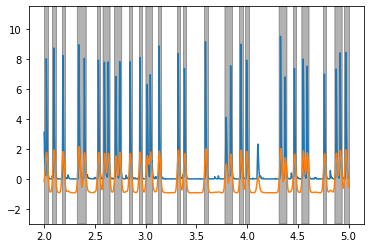

0.050751198692433115 0.08379398467021196


In [4]:
# Take one time trace and try to analyze the up and down states.
# My current idea is that we will have to define an absolute threshold of up state
fr_idx = 19
time_trace = FR_exc[:, fr_idx]

idx, train_shift, train_bool = detect_UP(FR_exc[:, fr_idx], ratioThreshold=0.3, len_state=20, gauss_width_ratio = 10,
                                        sampling_rate=1/parameters.parameter_integrator['dt'])
plt.plot(time_s, FR_exc[:, fr_idx])
ylim = (-3, np.amax(time_trace) + 2)

time_s = np.array(time_s, dtype=float)

plt.fill_between(time_s, min(ylim), max(ylim), where=train_bool == 1,
                color='k', alpha=0.3) #transform=ax.get_xaxis_transform())

plt.plot(time_s, train_shift)
plt.ylim(ylim)
plt.show()
up_mean_len, down_mean_len = mean_UD_duration(FR_exc, dt=parameters.parameter_integrator['dt'],
                                                  ratio_threshold=0.3, len_state=20, gauss_width_ratio=10)
print(up_mean_len, down_mean_len)

# Functional Connectivity. Trying to see if we can get close to DMN and other networks

Make use of the different regions and their indexes of the whole brain model to try to relate it to DMN.

In [15]:
cortex, conn, hem_left, hem_right = prepare_surface_regions_human(parameters, 
                                                                  conn_filename='Connectivity.zip',
                                                                  zip_filename='Surface_Cortex.zip',
                                                                  region_map_filename='RegionMapping.txt')
the_data = np.zeros((cortex.region_mapping_data.array_data.shape[0],))

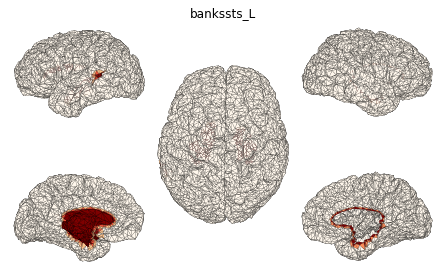

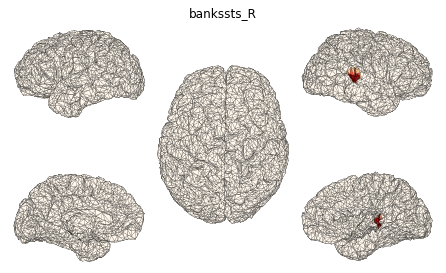

KeyboardInterrupt: 

In [14]:
for id_region in range(len(conn.region_labels)):
    multiview_one(cortex, hem_left, hem_right, 
                  [id_region], the_data, plt.figure(), suptitle='', 
                  title=conn.region_labels[id_region], figsize=(8, 8), shaded=False)
    plt.show()
    plt.close()

In [16]:
# List of the regions in our model
print(conn.region_labels)

['bankssts_L' 'bankssts_R' 'caudalanteriorcingulate_L'
 'caudalanteriorcingulate_R' 'caudalmiddlefrontal_L'
 'caudalmiddlefrontal_R' 'cuneus_L' 'cuneus_R' 'entorhinal_L'
 'entorhinal_R' 'frontalpole_L' 'frontalpole_R' 'fusiform_L' 'fusiform_R'
 'inferiorparietal_L' 'inferiorparietal_R' 'inferiortemporal_L'
 'inferiortemporal_R' 'insula_L' 'insula_R' 'isthmuscingulate_L'
 'isthmuscingulate_R' 'lateraloccipital_L' 'lateraloccipital_R'
 'lateralorbitofrontal_L' 'lateralorbitofrontal_R' 'lingual_L' 'lingual_R'
 'medialorbitofrontal_L' 'medialorbitofrontal_R' 'middletemporal_L'
 'middletemporal_R' 'paracentral_L' 'paracentral_R' 'parahippocampal_L'
 'parahippocampal_R' 'parsopercularis_L' 'parsopercularis_R'
 'parsorbitalis_L' 'parsorbitalis_R' 'parstriangularis_L'
 'parstriangularis_R' 'pericalcarine_L' 'pericalcarine_R' 'postcentral_L'
 'postcentral_R' 'posteriorcingulate_L' 'posteriorcingulate_R'
 'precentral_L' 'precentral_R' 'precuneus_L' 'precuneus_R'
 'rostralanteriorcingulate_L' 'ro

# List of regions that are involved in DMN in litterature

Main functional hubs of the DMN:
- medial prefrontal cortex
- posterior cingulate cortex / precuneus
- angular gyrus

# Posterior cingulate / precuneus
We have both the posterior cingulate cortex and the precuneus in our lists

In [17]:
for i, label in enumerate(conn.region_labels):
    if 'posteriorcingulate' in label or 'precuneus' in label:
        print(f'region {label} has index {i}')

region posteriorcingulate_L has index 46
region posteriorcingulate_R has index 47
region precuneus_L has index 50
region precuneus_R has index 51


The default mode network is most commonly defined with resting state data by putting a seed in the Posterior cingulate cortex and examining which other brain areas most correlate with this area.


Independent component analysis (ICA) robustly finds the DMN for individuals and across groups, and has become the standard tool for mapping the default network.


It has been shown that the default mode network exhibits the highest overlap in its structural and functional connectivity, which suggests that the structural architecture of the brain may be built in such a way that this particular network is activated by default. Very interesting! Indicates that we should be able to get closer to it having the connectome!
(all from Wikipedia but it's cited and looks okay)

# Looking for the angular gyrus in our model

Inferioparietal i think are the closest ones to the angular gyrus. Additionally, the supramarginal gyrus is also really close

In [18]:
for i, label in enumerate(conn.region_labels):
    if 'inferio' in label or 'supramarginal' in label or 'isthmus' in label:
        print(f'region {label} has index {i}')

region inferiorparietal_L has index 14
region inferiorparietal_R has index 15
region inferiortemporal_L has index 16
region inferiortemporal_R has index 17
region isthmuscingulate_L has index 20
region isthmuscingulate_R has index 21
region supramarginal_L has index 62
region supramarginal_R has index 63


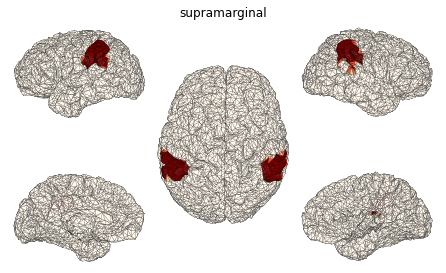

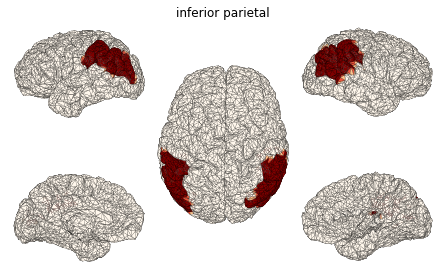

In [19]:
id_regions = [62, 63]
title = 'supramarginal'
multiview_one(cortex, hem_left, hem_right, 
              [62, 63], the_data, plt.figure(), suptitle='', 
              title=title, figsize=(8, 8), shaded=False)

id_regions = [14, 15, 62, 63]
title = 'inferior parietal'
multiview_one(cortex, hem_left, hem_right, 
              id_regions, the_data, plt.figure(), suptitle='', 
              title=title, figsize=(20, 20), shaded=False)

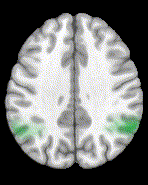
https://upload.wikimedia.org/wikipedia/commons/c/c4/Angular_gyrus_sagittal_sections.gif
https://upload.wikimedia.org/wikipedia/commons/a/a3/Angular_gyrus_transversal_sections.gif
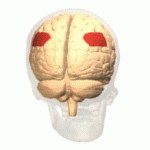

# Looking for the medial prefrontal cortex

What does the medial prefrontal cortex contain?
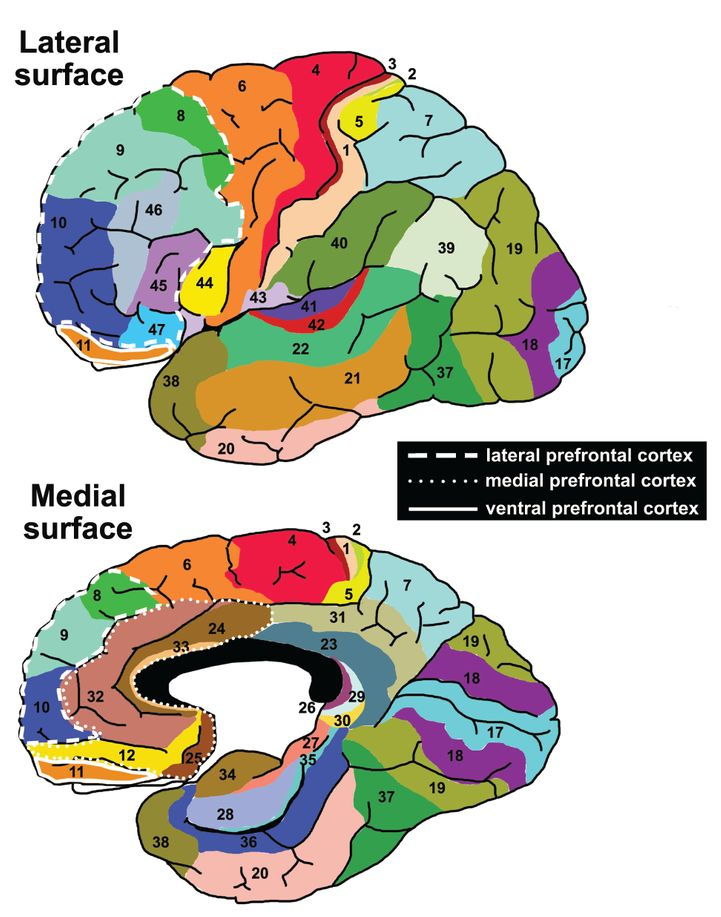
From this picture we consider that the Brodmann areas in the medial prefrontal cortex are:
- 24: Dorsal anterior cingulate cortex. I think only this one's missing
- 33: Rostral anterior cingulate cortex **There is one region with this name!**
- 32: Pregenual anterior cingulate cortex
- 12: No clear name. Possibly Orbitofrontal Area (orbital gyri, gyrus rectus, rostral gyrus and part of superior frontal gyrus) – receives information about the sight of objects as well as the reward value of taste. **We have medial oribitofrontal which actually takes a big chunk of space**
- 25: Subgenual anterior cingulate cortex

Let's plot them

In [20]:
for i, label in enumerate(conn.region_labels):
    if 'anteriorcingulate' in label or 'medialorbitofrontal' in label:
        print(f'region {label} has index {i}')

region caudalanteriorcingulate_L has index 2
region caudalanteriorcingulate_R has index 3
region medialorbitofrontal_L has index 28
region medialorbitofrontal_R has index 29
region rostralanteriorcingulate_L has index 52
region rostralanteriorcingulate_R has index 53


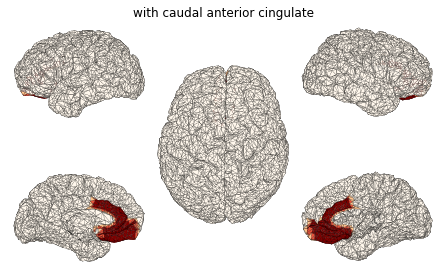

In [21]:
title = 'with caudal anterior cingulate'
multiview_one(cortex, hem_left, hem_right, 
              [2, 3, 28, 29, 52, 53], the_data, plt.figure(), suptitle='', 
              title=title, figsize=(8, 8), shaded=False)

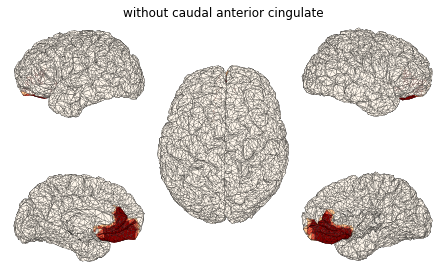

In [22]:
title = 'without caudal anterior cingulate'
multiview_one(cortex, hem_left, hem_right, 
              [28, 29, 52, 53], the_data, plt.figure(), suptitle='', 
              title=title, figsize=(8, 8), shaded=False)

# DMN nodes that we will use for the analyses

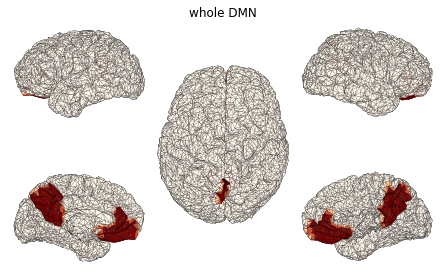

In [23]:
regions = [28, 29, 52, 53,  # mPFC
          50, 51, 20, 21]  # precuneus and posterior cingulate (seems large)

# Angular gyrus will be ignored from now on. Should be discussed afterwards

# I would maybe skip regions 2, 3 and maybe regions 14, 15.  
title = 'whole DMN'
multiview_one(cortex, hem_left, hem_right, 
              regions, the_data, plt.figure(), suptitle='', 
              title=title, figsize=(8, 8), shaded=False)

In [24]:
# So now we want to take the nodes in the DMN and the ones that are not in the DMN and obtain their
# correlations
DMN_regions = [28, 29, 52, 53,  # mPFC
               50, 51, 20, 21]  # precuneus / posterior cingulate
corrs_in_DMN = []
corrs_out_DMN = []
corrs_in_out_DMN = []

# We make use of the FR_exc obtained
N, M = FR_exc.shape
FC = np.corrcoef(FR_exc.T)

for i in range(M):
    for j in range(M):
        if i == j:
            continue
        corr = FC[i , j]
        if i in DMN_regions and j in DMN_regions:
            corrs_in_DMN.append(corr)
        elif any(n in DMN_regions for n in (i, j)):
            corrs_in_out_DMN.append(corr)
        else:
            corrs_out_DMN.append(corr)

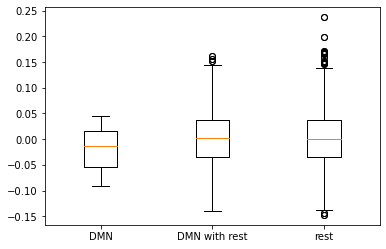

In [25]:
labels = ['DMN', 'DMN with rest', 'rest']
plt.boxplot([corrs_in_DMN, corrs_in_out_DMN, corrs_out_DMN], labels = labels)
plt.show()

In [116]:
def plot_corr_dmn(fr, dmn_regions=None, type_plot='box', jitter=True):
    """ Shows box or violin plot of the statistics of correlation between nodes in the TVB.
    Separates in three groups:
    - Correlations between nodes of the Default Mode Network (DMN)
    - Correlations between nodes of the DMN and other nodes
    - Correlations between nodes not of the DMN

    The last one being, usually, the largest group of the three.

    Parameters
    ----------
    fr: ndarray
        Numpy array of shape (N, M) containing the firing rates of M regions.

    dmn_regions: list
        Contains the indexes of the M regions that belong to the Default Mode Network.

    type_plot: str
        Either 'box' or 'violin'.

    jitter: bool
        Determines whether we want to plot all the data points.

    Returns
    -------
    fig: matplotlib.pyplot fig object
    ax: matplotlib.pyplot axes object
        Shows statistics of correlations between the different nodes in the network.
    """

    if dmn_regions is None:
        dmn_regions = [28, 29, 52, 53,  # mPFC
                       50, 51, 20, 21]  # precuneus / posterior cingulate
    corrs_in_DMN = []
    corrs_out_DMN = []
    corrs_in_out_DMN = []

    # We make use of the FR_exc obtained
    N, M = fr.shape
    FC = np.corrcoef(fr.T)

    for i in range(M):
        for j in range(i): # If we want to take only one triangular portion of the matrix.
        #for j in range(M):
            if i == j:  # Not interested in diagonal
                continue
            corr = FC[i, j]
            if i in dmn_regions and j in dmn_regions:
                corrs_in_DMN.append(corr)
            elif any(n in dmn_regions for n in (i, j)):
                corrs_in_out_DMN.append(corr)
            else:
                corrs_out_DMN.append(corr)

    # Saving results in a dataframe
    df_in_DMN = pd.DataFrame({'group': np.repeat('DMN', len(corrs_in_DMN)),
                              'corr': corrs_in_DMN})

    df_in_out_DMN = pd.DataFrame({'group': np.repeat('DMN with others', len(corrs_in_out_DMN)),
                                  'corr': corrs_in_out_DMN})

    df_out_DMN = pd.DataFrame({'group': np.repeat('others', len(corrs_out_DMN)),
                               'corr': corrs_out_DMN})

    data = pd.concat([df_in_DMN, df_in_out_DMN, df_out_DMN])

    # Plotting
    fig, ax = plt.subplots(1, 1, figsize=(8, 5))
    ax.set(ylim=(-1, 1))
    if type_plot == 'box':
        sns.boxplot(x='group', y='corr', data=data, ax=ax)

    elif type_plot == 'violin':
        sns.violinplot(x='group', y='corr', data=data, ax=ax)
    else:
        raise ValueError('Incorrect choice of type_plot (either box or violin)')

    if jitter:
        sns.stripplot(x='group', y='corr', data=data, color="orange", jitter=0.2, size=2, ax=ax)
        
    return fig, ax

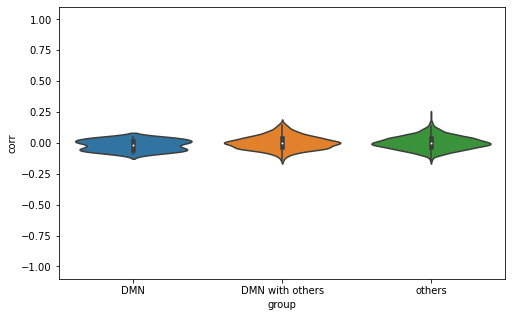

In [5]:
fig, ax = plot_corr_dmn(corr_dmn(FR_exc), type_plot='violin', jitter=False)
plt.show()

# Let's obtain the plots for the original set of parameters and b=0 and b=60

In [58]:
parameters = Parameter()
bs = [0, 60]
folder_root = os.getcwd() + '/results_test_DMN/'
sim = False

if sim:
    for simnum in range(len(bs)):
        parameters.parameter_model['b_e'] = bs[simnum]

        label_sim = '_b_e' + str(bs[simnum]) + '/'

        file_name = folder_root + label_sim
        parameters.parameter_simulation['path_result'] = file_name

        # Set up simulator with new parameters
        simulator = tools.init(parameters.parameter_simulation, parameters.parameter_model,
                               parameters.parameter_connection_between_region,
                               parameters.parameter_coupling,
                               parameters.parameter_integrator,
                               parameters.parameter_monitor)

        # Run simulations
        tools.run_simulation(simulator, run_sim, parameters.parameter_simulation, parameters.parameter_monitor)

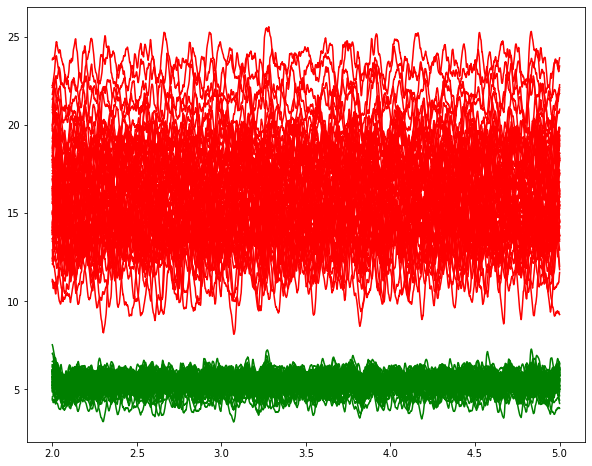

742.5402355371309


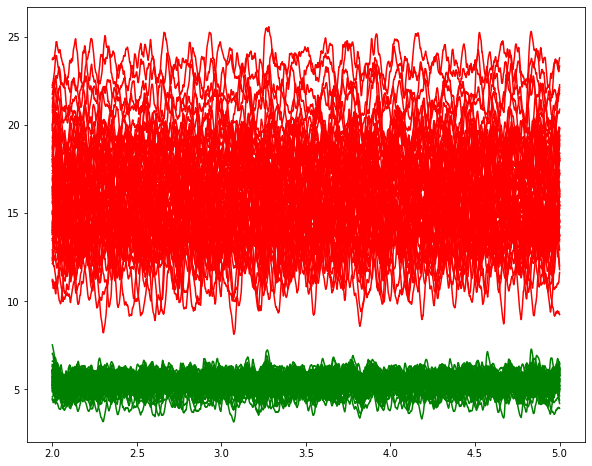

405.93183612607766


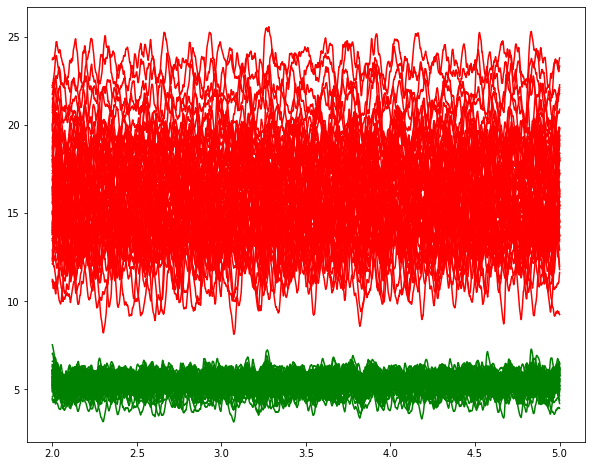

406.6091930695618


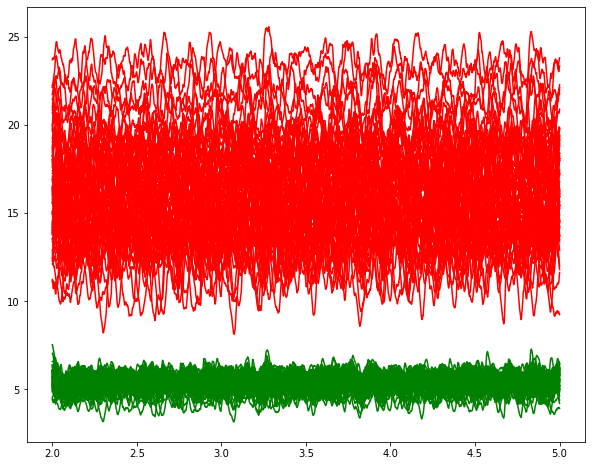

485.8892927390393


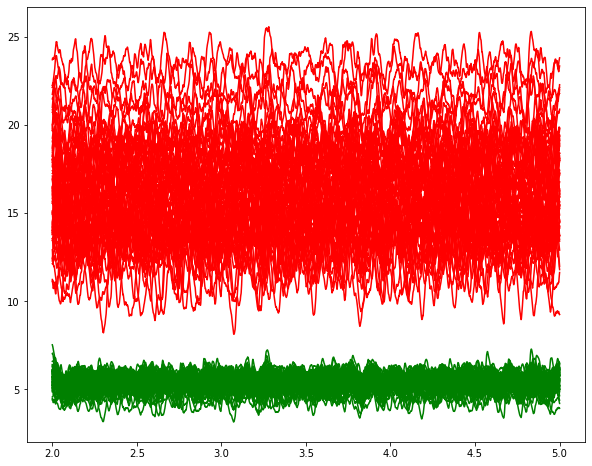

80.96241226747671


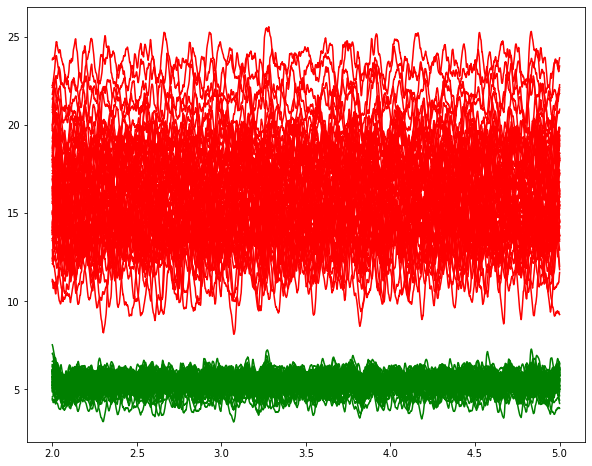

266.0878935634035


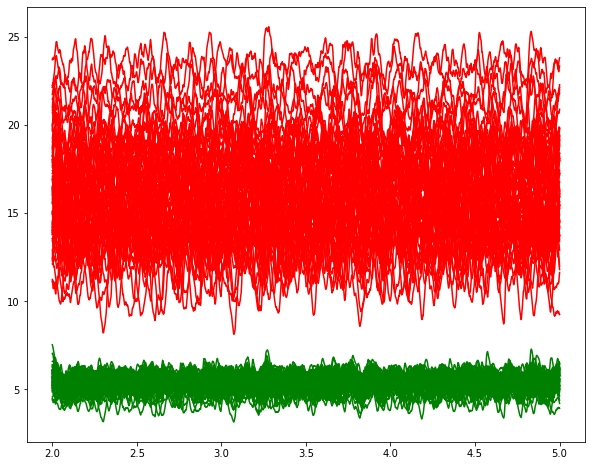

171.29445817518473


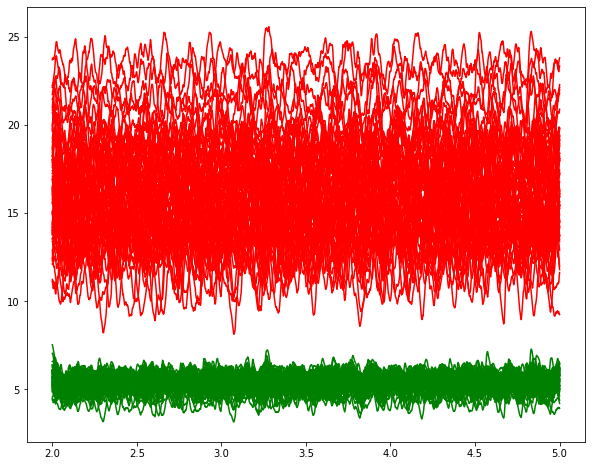

289.565960126305


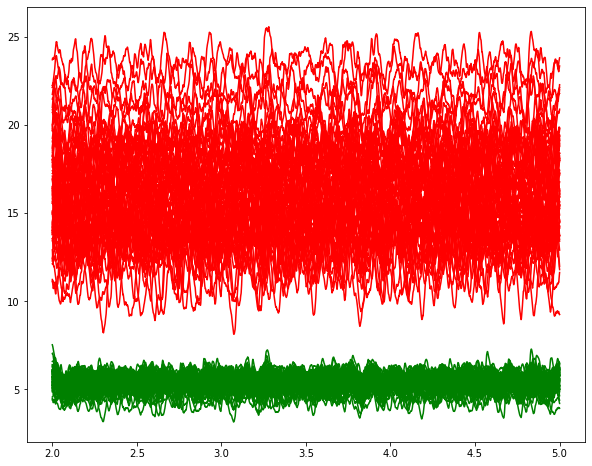

144.9679015601323


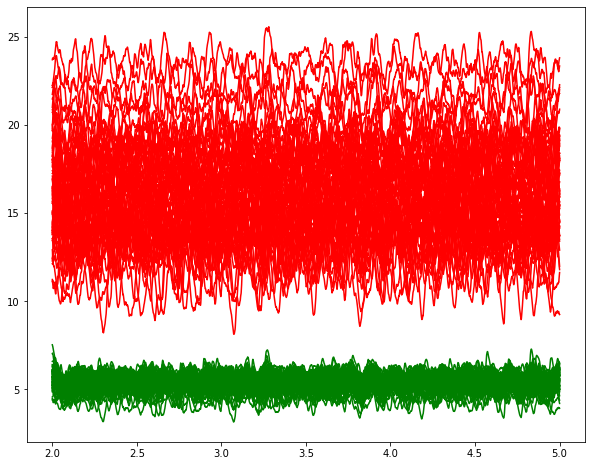

254.5140828193248


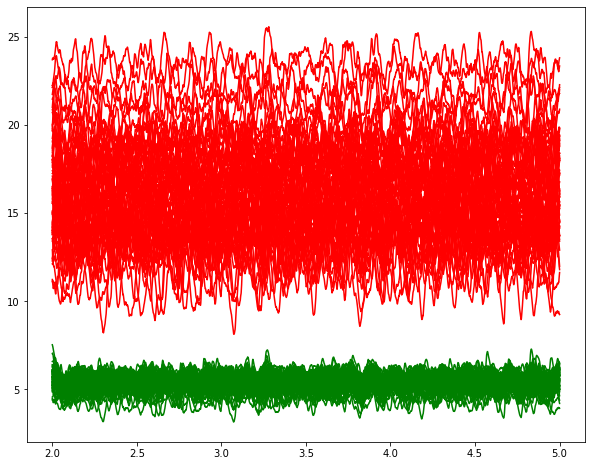

85.32409488846253


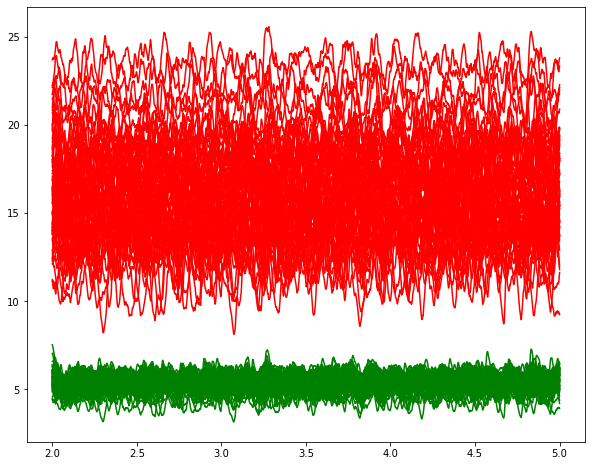

208.96883300517402


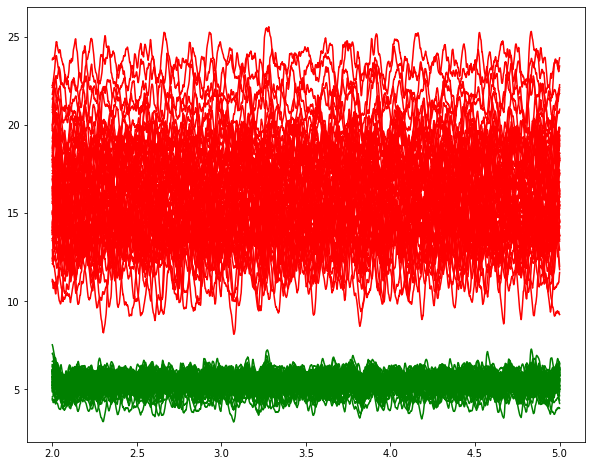

129.89125149935848


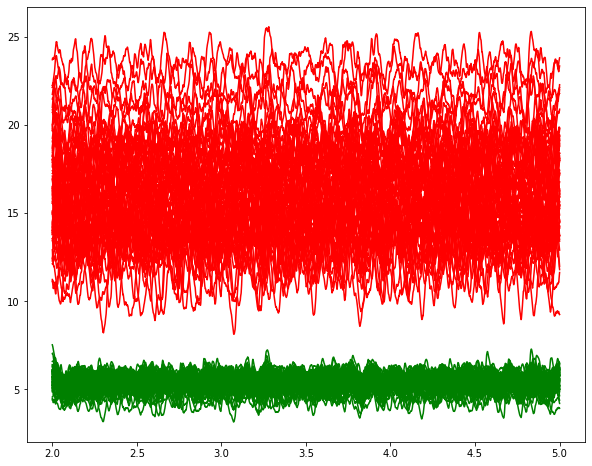

534.8565189080496


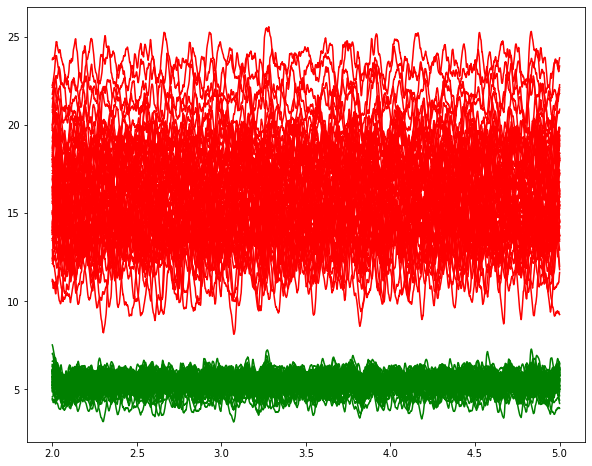

854.6183951142044


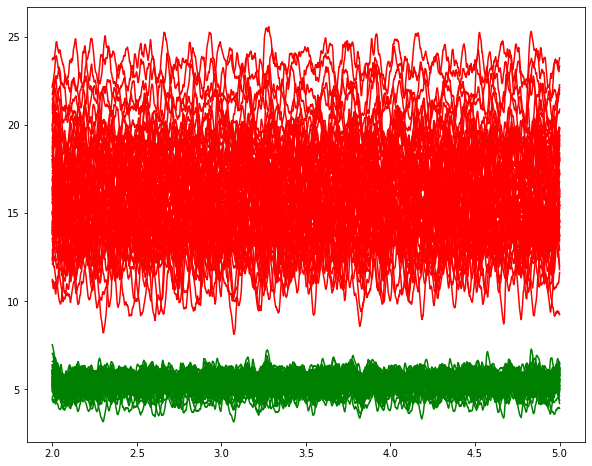

294.0592618497851


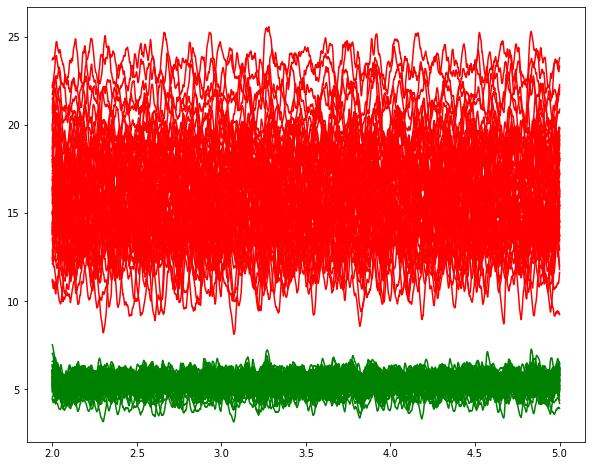

218.57932547016702


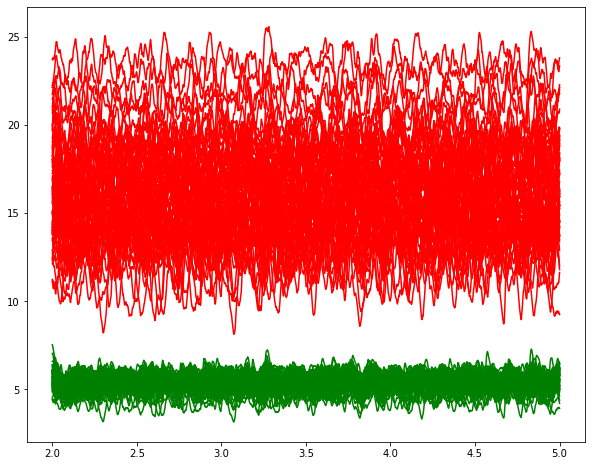

458.3210336061809


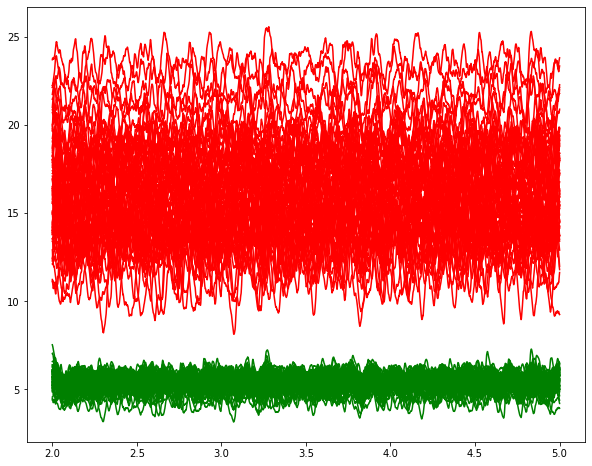

36.43197965093842


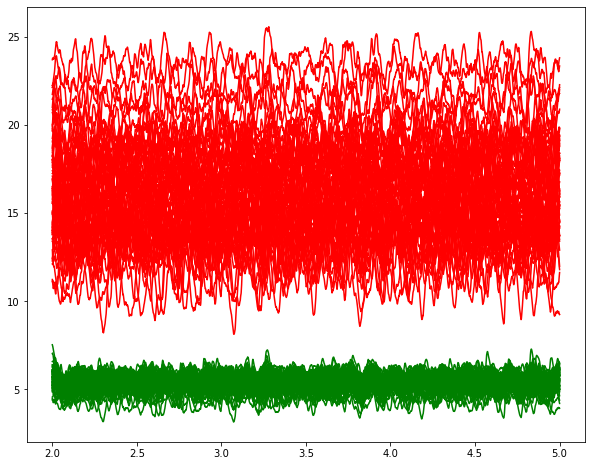

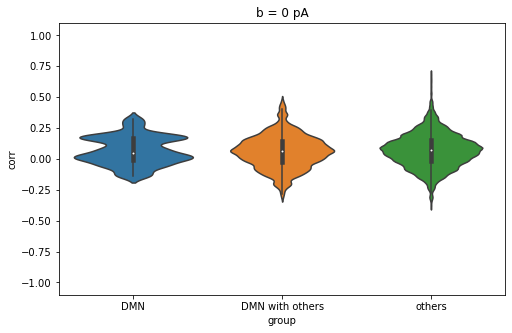

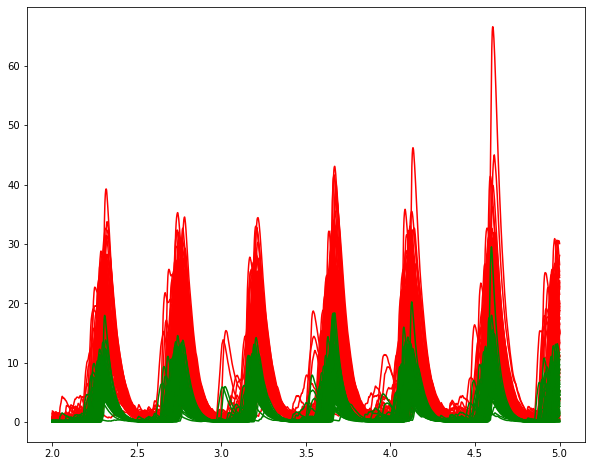

4948308.006231867


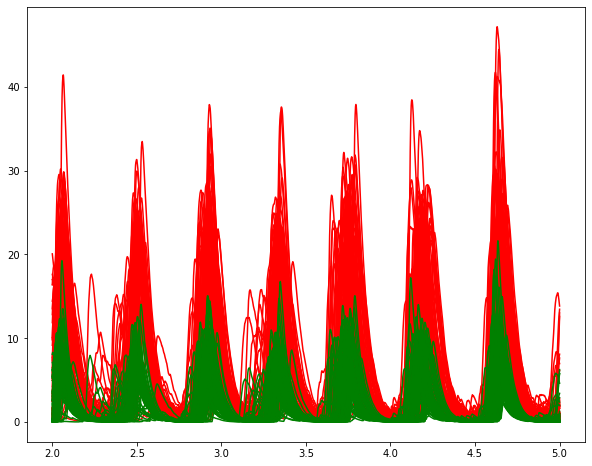

5987993.470294524


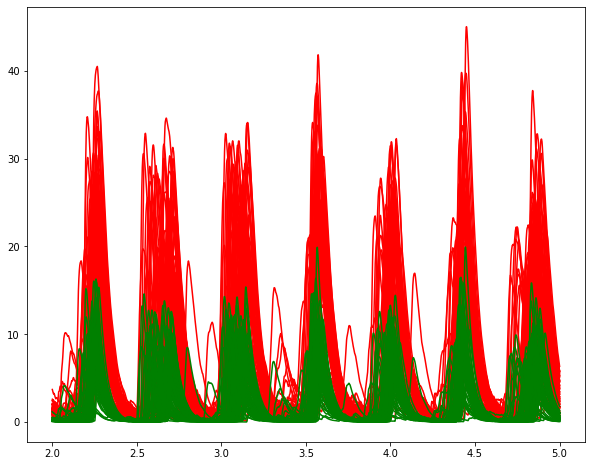

1933421.6880962395


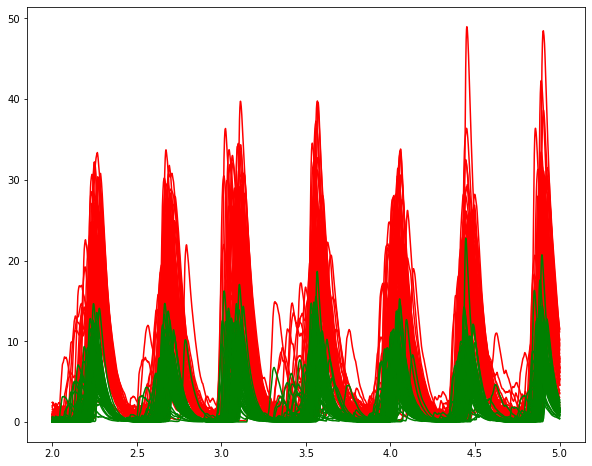

3608353.6429262906


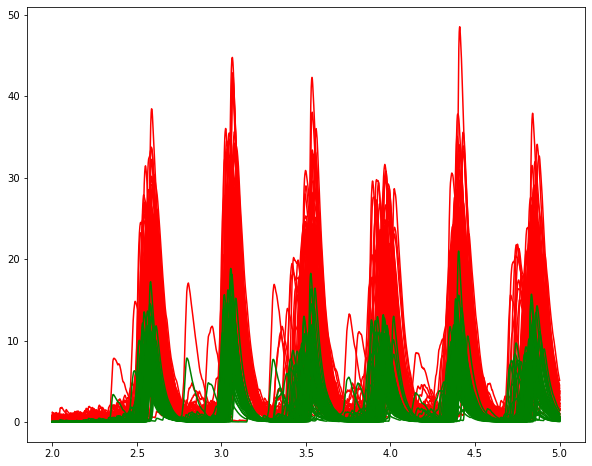

4746123.8946999125


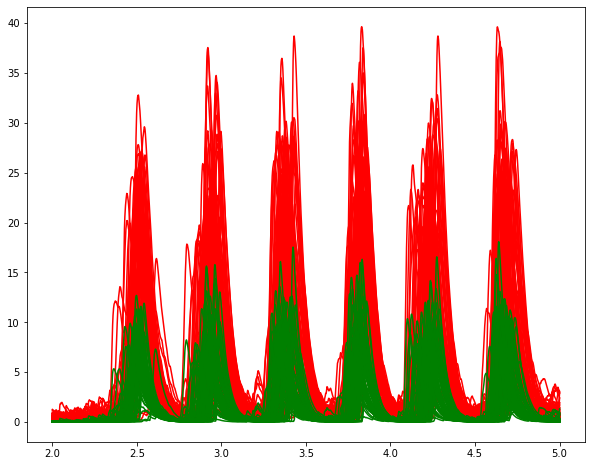

1756363.507528674


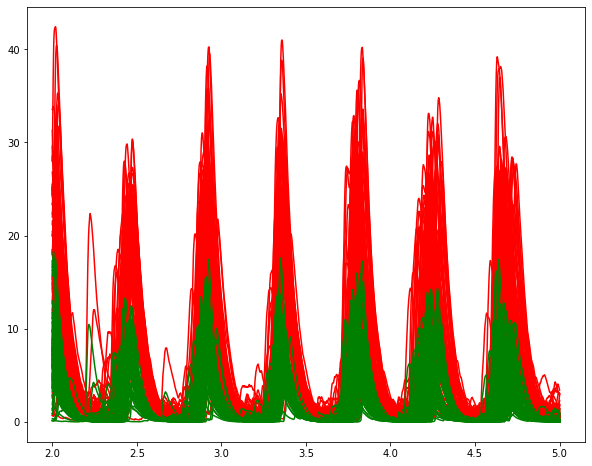

3083808.123407206


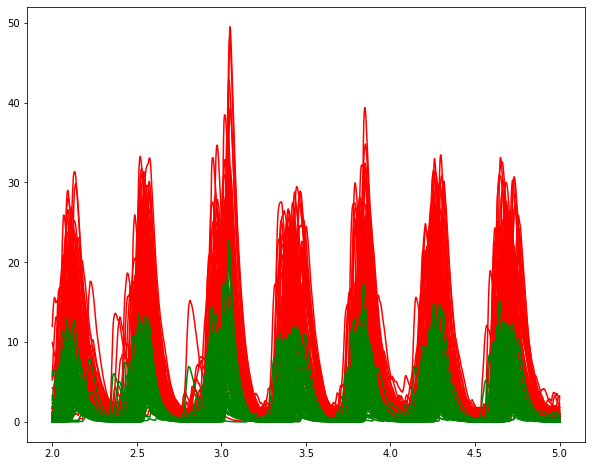

4903994.229504458


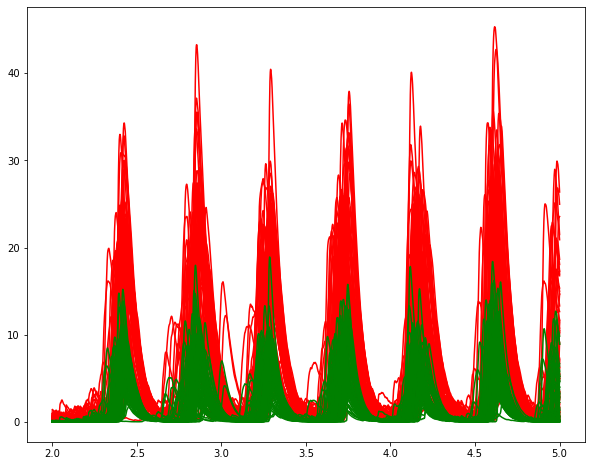

3810078.865623481


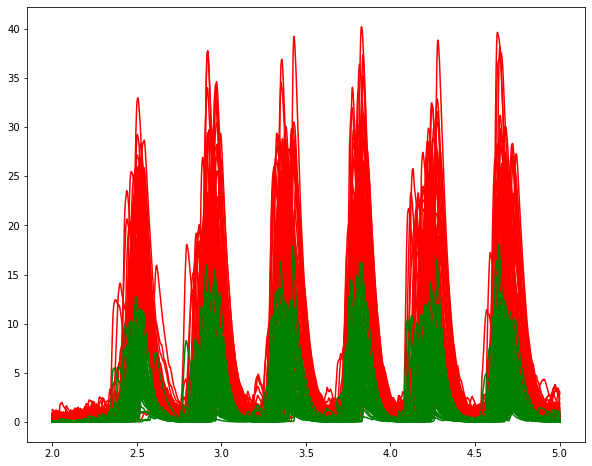

4928748.371094468


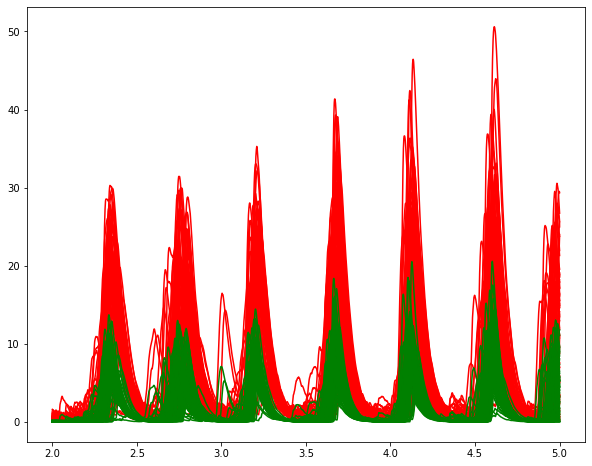

2730837.652935879


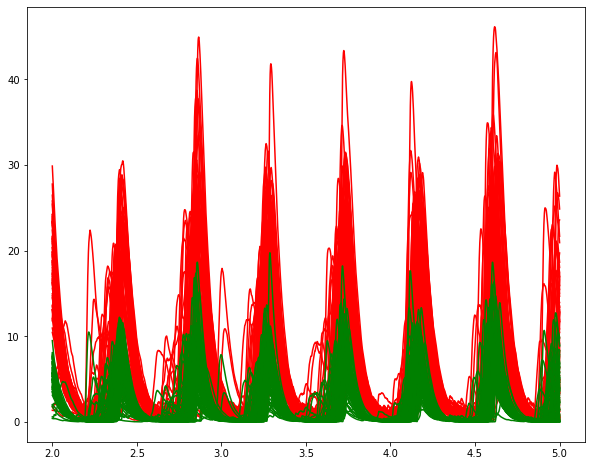

4206004.963636407


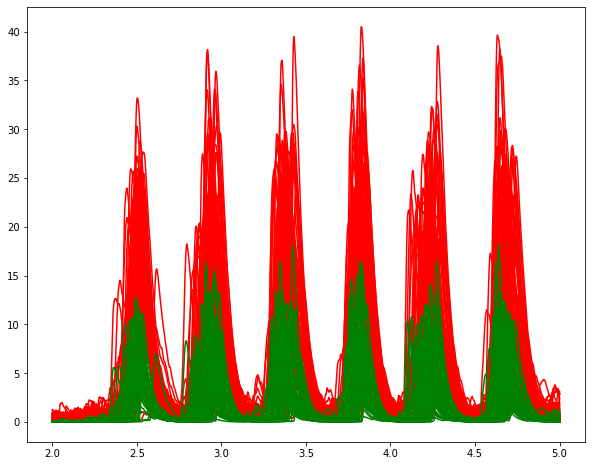

4884312.395231282


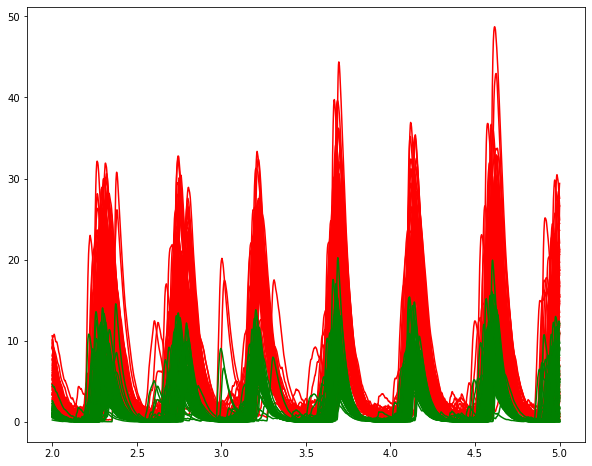

5054149.315801637


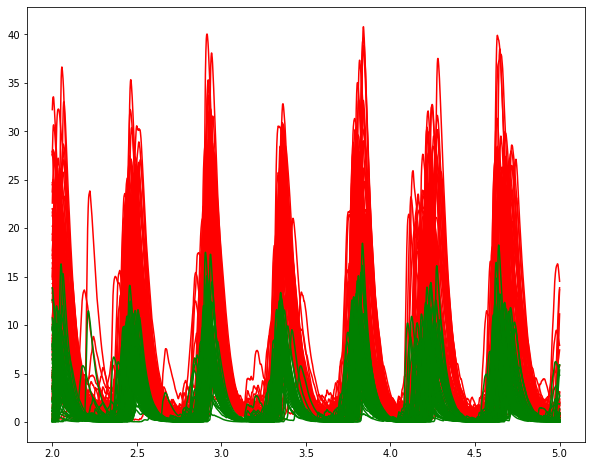

5736589.948060377


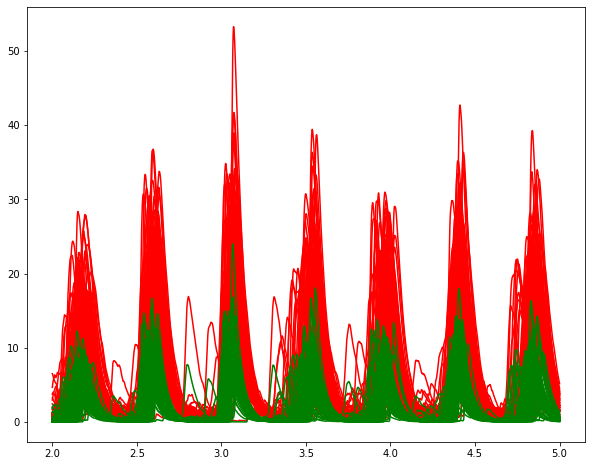

5867558.194723658


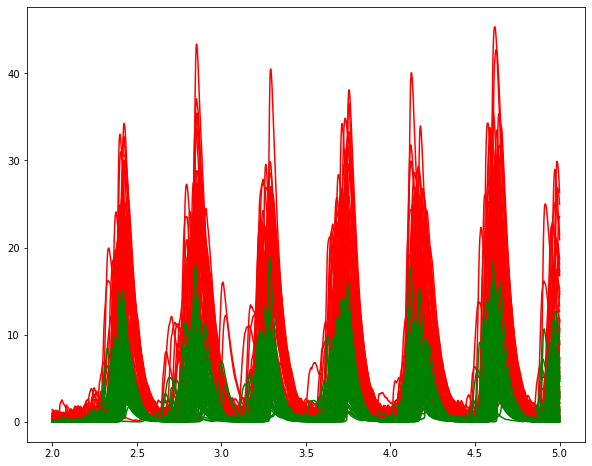

5094895.286183124


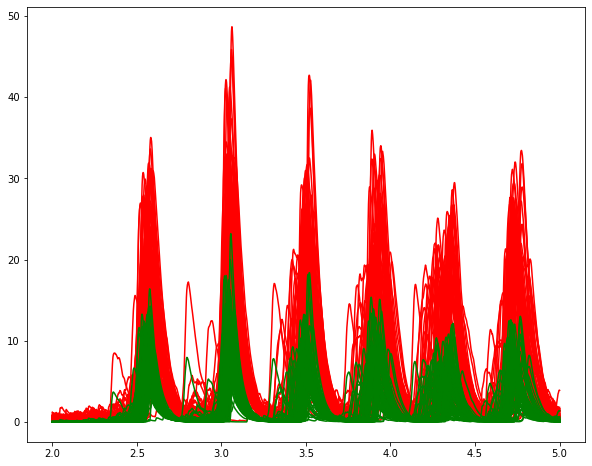

3769582.498862507


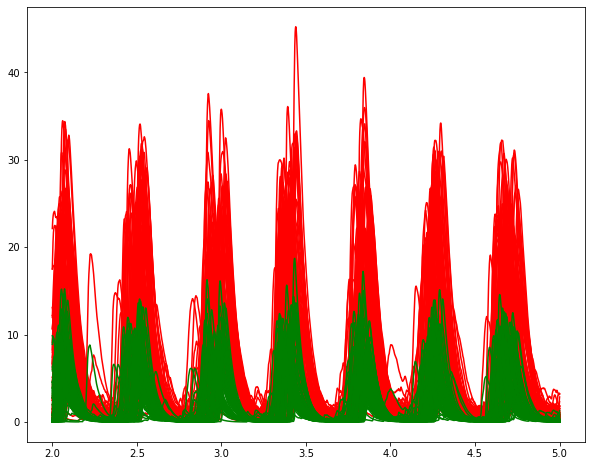

5927800.130443919


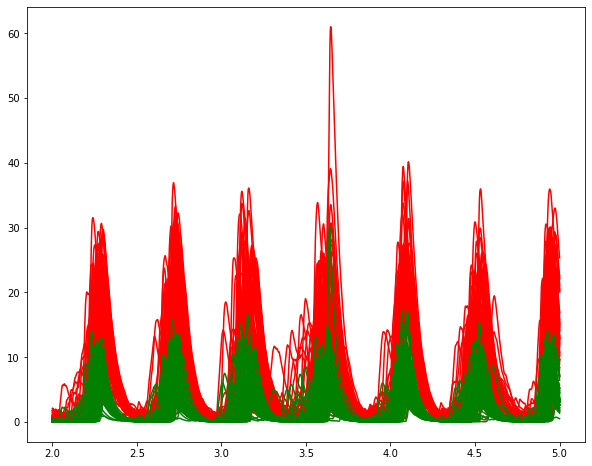

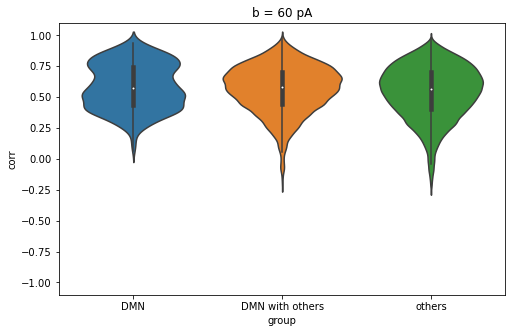

In [63]:
steps = 20
seeds = np.arange(20, 20+steps)
for b in bs:
    datas = []
    for seed in seeds:
        label_sim = '_b_' + str(b) + '_s_' + str(seed) + '/'
        file_name = folder_root + label_sim
        result = tools.get_result(file_name, cut_transient, run_sim)
        time_s = result[0][0] * 1e-3  # from ms to sec

        # Decide which one to analyze since they usually exhibit very similar behavior
        FR_exc = result[0][1][:, 0, :] * 1e3  # from KHz to Hz; Excitatory firing rate
        FR_inh = result[0][1][:, 1, :] * 1e3  # from KHz to Hz; Inhibitory firing rate
        datas.append(corr_dmn(FR_exc))
        if seed > 20:
            print(np.sum(np.abs(FR_exc - FR_old)))
        FR_old = FR_exc
        fig, ax = plt.subplots(1, 1, figsize=(10, 8))
        ax.plot(time_s, FR_inh, label=r'$v_i$', c='r')
        ax.plot(time_s, FR_exc, label=r'$v_e$', c='g')
        #ax.set(title=f'S: {S}', xlabel='Time(s)', ylabel='FR(Hz)',
        #      xlim=(2, 5), ylim=(0, 5 + max([np.amax(FR_exc), np.amax(FR_inh)])))
        plt.show()
        
    data = pd.concat(datas)
    fig, ax = plot_corr_dmn(data, type_plot='violin', jitter=False)
    ax.set_title(f'b = {b} pA')
    plt.show()

# Check now the division of the average. See if there are regularities in activation. With this maybe fMRI methods to see which regions (voxels) are correlated between them. Then plot the indexs in the map and see if they look like the DMN.

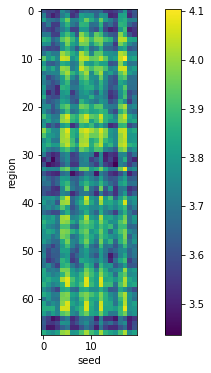

In [124]:
avgs = np.empty((68, seeds.size))
for ii, seed in enumerate(seeds):
    datas = []
    FRs = []
    for b in bs:
        label_sim = '_b_' + str(b) + '_s_' + str(seed) + '/'
        file_name = folder_root + label_sim
        result = tools.get_result(file_name, cut_transient, run_sim)
        time_s = result[0][0] * 1e-3  # from ms to sec

        # Decide which one to analyze since they usually exhibit very similar behavior
        FR_exc = result[0][1][:, 0, :] * 1e3  # from KHz to Hz; Excitatory firing rate
        FR_inh = result[0][1][:, 1, :] * 1e3  # from KHz to Hz; Inhibitory firing rate
        FRs.append(FR_exc)
    
    avgs[:, ii] = np.mean(FRs[0], axis=0)- np.mean(FRs[1], axis=0)


fig, ax = plt.subplots(1, 1, figsize=(10, 6))
im = ax.imshow(avgs)
ax.set(xlabel='seed', ylabel='region')
plt.colorbar(im)
plt.show()

[12  6 56 25 10 28 26 22]


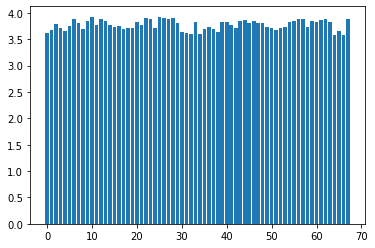

In [125]:
mean_regions = np.mean(avgs, axis=1)
plt.bar(np.arange(0, 68), mean_regions)
np.argmin(mean_regions)
k = 8

idx = np.argpartition(mean_regions, -k)[-k:]
print(idx)

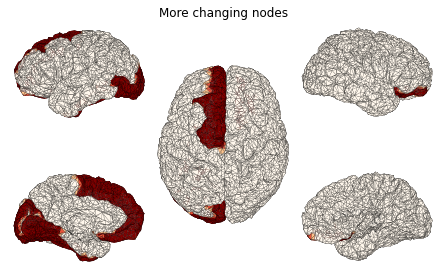

In [126]:
cortex, conn, hem_left, hem_right = prepare_surface_regions_human(parameters, 
                                                                  conn_filename='Connectivity.zip',
                                                                  zip_filename='Surface_Cortex.zip',
                                                                  region_map_filename='RegionMapping.txt')
the_data = np.zeros((cortex.region_mapping_data.array_data.shape[0],))

title = 'More changing nodes'
multiview_one(cortex, hem_left, hem_right, 
              idx.tolist(), the_data, plt.figure(), suptitle='', 
              title=title, figsize=(8, 8), shaded=False)

# Seeding approach

How do we do the seeding approach? We take the the precuneus as the seed region and obtain the correlations of all the other regions with this seed. We can do both left and right and see the brain maps. Then we apply Fisher's transofmration to obtain z-scores and afterwards we plot the maps. It would be cool to threshold and do the colormaps like they do on actual fMRI data. However, that will probably be quite complicated to modify from the original functions.